### Libraries

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from itertools import product

### Model - Walk Forward

In [47]:
def build_and_train_model(X_train, y_train, 
                          X_val, y_val, 
                          dropout_rate=0.2, 
                          learning_rate=0.001, 
                          epochs=10, 
                          batch_size=32, 
                          verbose=0):
    """
    Builds and trains a simple LSTM model for demonstration.
    Returns the trained model and the RMSE on the validation set.
    """
    # 1) Build the model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Explicit input layer
    model.add(LSTM(50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # single numeric output

    # 2) Compile
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    # 3) Fit
    model.fit(X_train, y_train, 
              validation_data=(X_val, y_val),
              epochs=epochs, 
              batch_size=batch_size, 
              verbose=verbose)

    # 4) Compute validation RMSE
    y_val_pred = model.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

    return model, rmse_val

def walk_forward_prediction(X, y, param_grid, window_size=2, verbose=True):
    """
    Example walk-forward function:
      - Slices (train, val, test) by shifting one step each iteration.
      - Grid-searches hyperparams on (train, val).
      - Uses the best model to predict the test point.

    :param X: np.array, shape (N, num_features)
    :param y: np.array, shape (N,)
    :param param_grid: dict, e.g. {
         'dropout_rate': [0.0, 0.2],
         'learning_rate': [0.001, 0.0001],
         'epochs': [10, 20]
      }
    :param window_size: int, how many points in the training window
    :param verbose: bool, if True print progress statements

    :return:
      all_preds    : list of predictions
      all_y_true   : list of actual y test values
      all_test_idxs: list of test indices
    """
    
    n = len(X)
    all_preds = []
    all_y_true = []
    all_test_idxs = []
    
    # We'll define the total number of folds (how many test steps we do):
    #   test_index goes from (window_size+1) to n-1 inclusive
    #   so total_folds = (n-1) - (window_size+1) + 1 = n - (window_size+2)
    total_folds = n - (window_size + 1)

    # Pre-calculate total hyperparameter combos for grid search
    # (the product of lengths of all lists in param_grid)
    param_keys, param_values = zip(*param_grid.items())
    total_combos = 1
    for v in param_values:
        total_combos *= len(v)

    fold_count = 0  # to track which fold we are on

    # Main loop to slide the test_index
    for test_index in range(window_size + 1, n):
        fold_count += 1
        if verbose:
            print(f"\n=== Fold {fold_count}/{total_folds}: Test index = {test_index} ===")

        # train indices: [test_index - (window_size + 1), ..., test_index-2]
        # val index: test_index-1
        # test index: test_index
        train_start = test_index - (window_size + 1)
        train_end   = train_start + window_size  # not inclusive
        val_index   = train_end
        # test_index is defined in the loop

        # 1) Slice out data
        X_train = X[train_start:train_end]
        y_train = y[train_start:train_end]

        X_val   = X[val_index : val_index+1]
        y_val   = y[val_index : val_index+1]

        X_test  = X[test_index : test_index+1]
        y_test  = y[test_index : test_index+1]

        # 2) Reshape for LSTM if needed (samples, timesteps=1, features)
        #    Just as a simple example:
        X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
        X_val_lstm   = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
        X_test_lstm  = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

        # 3) Grid search over param_grid
        best_rmse = float('inf')
        best_model = None

        # Prepare all combinations of hyperparameters
        combo_count = 0
        for combo in product(*param_values):
            combo_count += 1
            params = dict(zip(param_keys, combo))

            if verbose:
                print(f"  - Fold {fold_count}, training combo {combo_count}/{total_combos}: {params}")

            # Train model on (X_train_lstm, y_train)
            model, rmse_val = build_and_train_model(
                X_train_lstm, y_train,
                X_val_lstm, y_val,
                dropout_rate=params['dropout_rate'],
                learning_rate=params['learning_rate'],
                epochs=params['epochs'],
                verbose=0  # set to 1 or 2 if you want Keras logs
            )

            # Track best
            if rmse_val < best_rmse:
                best_rmse = rmse_val
                best_model = model

        # 4) Predict on test with best model
        y_test_pred = best_model.predict(X_test_lstm).ravel()  # shape (1,)

        # 5) Collect
        all_preds.append(y_test_pred[0])
        all_y_true.append(y_test[0])
        all_test_idxs.append(test_index)

    yield all_preds, all_y_true, all_test_idxs

### Model - standard

In [2]:
def build_and_train_model(
    X_train, y_train,
    X_val,   y_val,
    dropout_rate=0.2,
    learning_rate=0.001,
    epochs=10,
    batch_size=32,
    verbose=0
):
    """
    Builds and trains an LSTM model.
    Returns the trained model and the RMSE on the validation set.
    """
    # 1) Build the model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # explicit input layer
    model.add(LSTM(128, return_sequences = True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(64, return_sequences = True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(32))
    model.add(Dense(1))  # single numeric output

    # 2) Compile
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    # 3) Fit
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose
    )

    # 4) Compute validation RMSE
    y_val_pred = model.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

    return model, rmse_val

def gridsearch_lstm(
    X, y,
    train_prop=0.7, val_prop=0.15, test_prop=0.15,
    param_grid=None, verbose = 1
):
    """
    Splits (X, y) into train/val/test according to train_prop, val_prop, test_prop,
    then grid-searches an LSTM over param_grid on (train, val), 
    and returns predictions on the test set.

    :param X: 2D numpy array, shape (N, num_features).
    :param y: 1D numpy array, shape (N,).
    :param train_prop: float, proportion for training (e.g. 0.7).
    :param val_prop: float, proportion for validation (e.g. 0.15).
    :param test_prop: float, proportion for test (e.g. 0.15).
    :param param_grid: dict of lists, e.g. {
         'dropout_rate': [0.0, 0.2],
         'learning_rate': [0.01, 0.001],
         'epochs': [5, 10],
         'batch_size': [32, 64]
      }

    :return:
      - best_model: the Keras model that had the best val RMSE
      - test_preds: predictions of the best model on test set
      - y_test: true target values for test set
      - best_params: dict of hyperparams that gave the best val RMSE
      - test_rmse: RMSE on the test set
    """
    if param_grid is None:
        # A small default param grid
        param_grid = {
            'dropout_rate': [0.0, 0.2],
            'learning_rate': [0.001],
            'epochs': [5],
            'batch_size': [32]
        }

    n = len(X)
    # 1) Split indices
    train_end = int(n * train_prop)
    val_end   = int(n * (train_prop + val_prop))  # up to but not including
    # test is [val_end..]

    # 2) Slice data
    X_train_raw = X[:train_end]
    y_train_raw = y[:train_end]

    X_val_raw   = X[train_end:val_end]
    y_val_raw   = y[train_end:val_end]

    X_test_raw  = X[val_end:]
    y_test      = y[val_end:]

    # 3) Reshape for LSTM if you want (samples, timesteps=1, features)
    #    i.e. each sample is 1 time-step with 'num_features' inputs
    X_train = X_train_raw.reshape(X_train_raw.shape[0], 1, X_train_raw.shape[1])
    X_val   = X_val_raw.reshape(X_val_raw.shape[0], 1, X_val_raw.shape[1])
    X_test  = X_test_raw.reshape(X_test_raw.shape[0], 1, X_test_raw.shape[1])

    # 4) Grid Search
    best_rmse = float('inf')
    best_model = None
    best_params = None

    # Convert param_grid dict -> list of keys & list of lists for product
    param_keys, param_values = zip(*param_grid.items())  # e.g. (('dropout_rate','lr','epochs','batch_size'), ([0.0,0.2],[...],...))
    for combo in product(*param_values):
        current_params = dict(zip(param_keys, combo))

        # Train model on train, measure val RMSE
        model, rmse_val = build_and_train_model(
            X_train, y_train_raw,
            X_val,   y_val_raw,
            dropout_rate=current_params.get('dropout_rate', 0.2),
            learning_rate=current_params.get('learning_rate', 0.001),
            epochs=current_params.get('epochs', 10),
            batch_size=current_params.get('batch_size', 32),
            verbose = verbose
        )

        if rmse_val < best_rmse:
            best_rmse = rmse_val
            best_model = model
            best_params = current_params

    # 5) Predict on test with best model
    test_preds = best_model.predict(X_test).ravel()

    return test_preds, y_test, best_params, best_model

In [3]:
def get_tickers(path = 'Data\Real\Financial\microprocessor_stocks_2023-25.csv'):

    tickers = pd.read_csv(path)
    tickers = tickers['ticker'].unique()
    return tickers

def load_ticker(ticker, include_NLP = False):

    print(f'Loading {ticker}...')
    X = pd.read_csv(f'Data\ParsedDataForModel\{ticker}.csv')
    X['date'] = X['Unnamed: 0']
    X['date'] = pd.to_datetime(X['date'])
    X.index = X['date']

    # target variable
    #X.loc[:, 'change'] = X['close'].pct_change()
    X.loc[:, 'target'] = X['close'].shift(-1)
    X.loc[:, 'FMA'] = X['close'].rolling(window = '60min').mean()
    X.loc[:, 'SMA'] = X['close'].rolling(window = '5min').mean()
    X = X.dropna()

    y = X[['target']].copy()

    # log transform
    #X['volume'] = np.log(X['volume'])

    X = X.loc[X.index <= y.index[-1]]

    if include_NLP:

        # one hot encoding of categorical sentiment
        X = pd.concat(
            [X, pd.get_dummies(X[f'{ticker}_sentiment'])], axis = 1
        )

        X = X[['close', f'{ticker}_score', 'Negative', 'Positive', 'FMA', 'SMA']]
        X[['Negative', 'Positive']] = X[['Negative', 'Positive']].astype(int)
        
    else:
        X = X[['close', 'FMA', 'SMA']]
    

    return X, y

### Data

In [50]:
TICKERS = get_tickers()

In [51]:
ticker = TICKERS[0]

X_nlp, y_nlp = load_ticker(ticker, include_NLP = True)
X_base, y_base = load_ticker(ticker, include_NLP = False)

Loading NVDA...
Loading NVDA...


### Hyperparams space

In [52]:
hyperparams_grid = {
    'dropout_rate': [0.0],
    'learning_rate': [1e-3, 1],
    'epochs': [5]
}

In [53]:
test_preds_BASE, y_test_BASE, best_params_BASE, best_model_BASE = gridsearch_lstm(
    X = X_base.to_numpy(),
    y = y_base.to_numpy(),
    train_prop = 0.8,
    val_prop = 0.1,
    param_grid = hyperparams_grid,
    verbose = 1)

Epoch 1/5
25787/25787 ━━━━━━━━━━━━━━━━━━━━ 109s 4ms/step - loss: 845.8817 - val_loss: 3.6419
Epoch 2/5
25787/25787 ━━━━━━━━━━━━━━━━━━━━ 104s 4ms/step - loss: 0.3604 - val_loss: 1.4019
Epoch 3/5
25787/25787 ━━━━━━━━━━━━━━━━━━━━ 105s 4ms/step - loss: 0.2952 - val_loss: 0.8473
Epoch 4/5
25787/25787 ━━━━━━━━━━━━━━━━━━━━ 122s 5ms/step - loss: 0.2342 - val_loss: 0.5394
Epoch 5/5
25787/25787 ━━━━━━━━━━━━━━━━━━━━ 116s 5ms/step - loss: 0.1929 - val_loss: 1.0813
3224/3224 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
3224/3224 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [54]:
test_preds_NLP, y_test_NLP, best_params_NLP, best_model_NLP = gridsearch_lstm(
    X = X_nlp.to_numpy(),
    y = y_nlp.to_numpy(),
    train_prop = 0.8,
    val_prop = 0.1,
    param_grid = hyperparams_grid,
    verbose = 1)

Epoch 1/5
25787/25787 ━━━━━━━━━━━━━━━━━━━━ 104s 4ms/step - loss: 883.9769 - val_loss: 3.6766
Epoch 2/5
25787/25787 ━━━━━━━━━━━━━━━━━━━━ 101s 4ms/step - loss: 0.4191 - val_loss: 1.7482
Epoch 3/5
25787/25787 ━━━━━━━━━━━━━━━━━━━━ 101s 4ms/step - loss: 0.3864 - val_loss: 0.4488
Epoch 4/5
25787/25787 ━━━━━━━━━━━━━━━━━━━━ 100s 4ms/step - loss: 0.2701 - val_loss: 7.1091
Epoch 5/5
25787/25787 ━━━━━━━━━━━━━━━━━━━━ 100s 4ms/step - loss: 0.2227 - val_loss: 0.0532
3224/3224 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
3224/3224 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


### Compare the predictions

In [79]:
y = y_nlp.copy()
y = y.iloc[-(len(y_test_BASE)):]

y['base'] = test_preds_BASE
y['nlp'] = test_preds_NLP

def sign_func(x, threshold = 0):
    if x > threshold:
        return 1
    elif x < -threshold:
        return -1
    else:
        return 0
    
y['base'] = y['base'].pct_change()
y['nlp'] = y['nlp'].pct_change()
y['target'] = y['target'].pct_change()

y['base'] = y['base'].apply(sign_func)
y['nlp'] = y['nlp'].apply(sign_func)

y['base'] = y['base'] * y['target']
y['nlp'] = y['nlp'] * y['target']

y['target'] = y['target'] + 1
y['nlp'] = y['nlp'] + 1
y['base'] = y['base'] + 1

y['target'] = y['target'].cumprod()
y['nlp'] = y['nlp'].cumprod()
y['base'] = y['base'].cumprod()

# Save the result
y.to_csv(f'Results/{ticker}_results.csv')

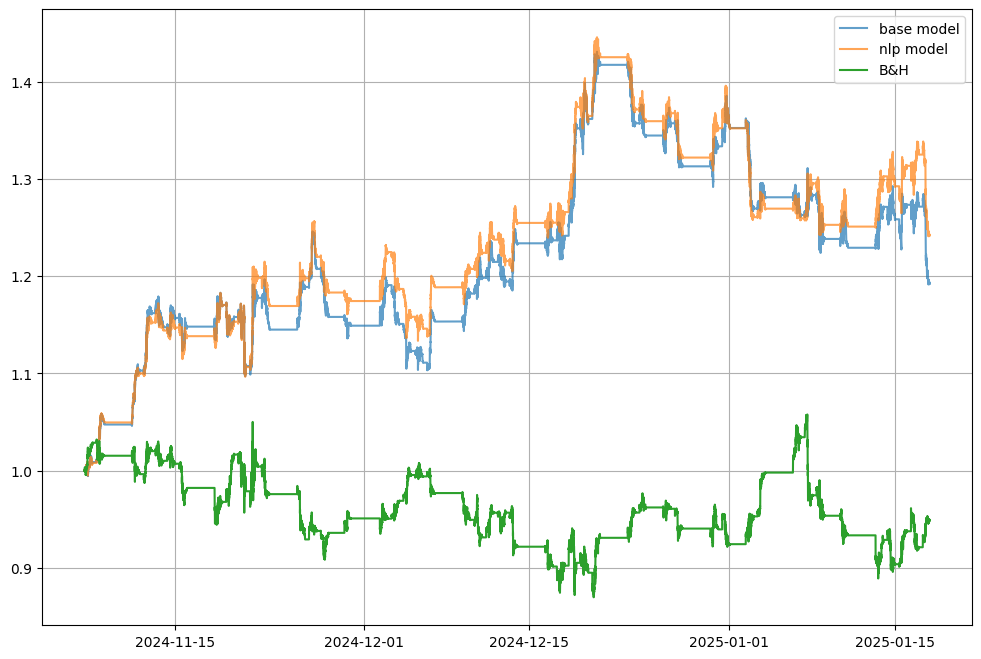

In [76]:
fig, ax1 = plt.subplots(figsize = (12,8))

ax1.plot(y['base'], label = 'base model', alpha = 0.7)
ax1.plot(y['nlp'], label = 'nlp model', alpha = 0.7)

ax1.plot(y['target'], label = 'B&H')

plt.grid(True)
plt.legend()
plt.show()

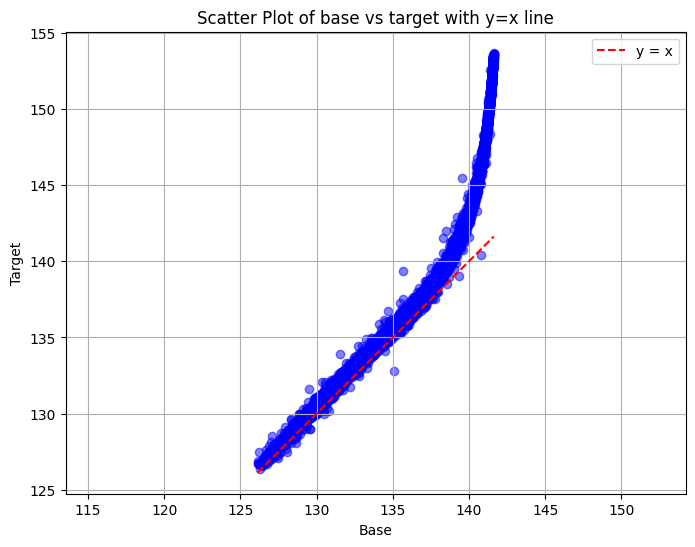

In [68]:
import numpy as np

y = y_nlp.copy()
y = y.iloc[-(len(y_test_BASE)):]
y['base'] = test_preds_BASE
y['nlp'] = test_preds_NLP

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y['base'], y['target'], color='blue', alpha=0.5)

# Plot the y = x line (add this part)
x_vals = np.linspace(min(y['base']), max(y['base']), 10000)  # Generate x values within the range of 'base'
plt.plot(x_vals, x_vals, color='red', linestyle='--', label='y = x')  # Line y = x

# Set the same scale for both axes
plt.axis('equal')  # This ensures that both axes have the same scaling

# Add titles and labels
plt.title('Scatter Plot of base vs target with y=x line')
plt.xlabel('Base')
plt.ylabel('Target')

# Display the grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

# Generate results for the entire basket

In [ ]:
hyperparams_grid = {
    'dropout_rate': [0.0],
    'learning_rate': [1e-3, 1e+1],
    'epochs': [5]
}

TICKERS = get_tickers()


for ticker in TICKERS:

    # Load the data
    X_nlp, y_nlp = load_ticker(ticker, include_NLP = True)
    X_base, y_base = load_ticker(ticker, include_NLP = False)

    # Train the LSTM and predict for BASE
    print(f'Doing base {ticker}...')
    test_preds_BASE, y_test_BASE, best_params_BASE, best_model_BASE = gridsearch_lstm(
        X = X_base.to_numpy(),
        y = y_base.to_numpy(),
        train_prop = 0.8,
        val_prop = 0.1,
        param_grid = hyperparams_grid,
        verbose = 1)

    # NLP
    print(f'Doing NLP {ticker}...')
    test_preds_NLP, y_test_NLP, best_params_NLP, best_model_NLP = gridsearch_lstm(
        X = X_nlp.to_numpy(),
        y = y_nlp.to_numpy(),
        train_prop = 0.8,
        val_prop = 0.1,
        param_grid = hyperparams_grid,
        verbose = 1)

    # Calculate schore
    y = y_nlp.copy()
    y = y.iloc[-(len(y_test_BASE)):]

    y['base'] = test_preds_BASE
    y['nlp'] = test_preds_NLP

    def sign_func(x, threshold = 0):
        if x > threshold:
            return 1
        elif x < -threshold:
            return -1
        else:
            return 0
        
    y['base'] = y['base'].pct_change()
    y['nlp'] = y['nlp'].pct_change()
    y['target'] = y['target'].pct_change()

    y['base'] = y['base'].apply(sign_func)
    y['nlp'] = y['nlp'].apply(sign_func)

    y['base'] = y['base'] * y['target']
    y['nlp'] = y['nlp'] * y['target']

    y['target'] = y['target'] + 1
    y['nlp'] = y['nlp'] + 1
    y['base'] = y['base'] + 1

    y['target'] = y['target'].cumprod()
    y['nlp'] = y['nlp'].cumprod()
    y['base'] = y['base'].cumprod()

    # Save the result
    y.to_csv(f'Results/{ticker}_results.csv')